# PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research paper into useable code

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch

https://arxiv.org/pdf/2010.11929v2.pdf

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    %cd ..
    from functions import data_setup, engine, utils, helper_functions
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/fbrynpk/Covid19-Prediction
    !move Covid19-Prediction/helper_functions.py .
    !move Covid19-Prediction/data_setup.py .
    !move Covid19-Prediction/engine.py .
    !move Covid19-Prediction/utils.py .
    !rd /s /q Covid19-Prediction/
    from functions import data_setup, engine, utils, helper_functions

/Users/fbrynpk/Downloads/Projects


In [3]:
# Setup device agnostic code
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
  
device

'mps'

## Get Data

The whole goal of what we're trying to do is replicate the ViT architecture to predict Covid-19 based on XRAY data

Let's get some data

In [5]:
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset


  0%|          | 0.00/28.0M [00:00<?, ?B/s]
  4%|▎         | 1.00M/28.0M [00:00<00:22, 1.26MB/s]
  7%|▋         | 2.00M/28.0M [00:00<00:10, 2.54MB/s]
 14%|█▍        | 4.00M/28.0M [00:01<00:04, 5.41MB/s]
 25%|██▍       | 7.00M/28.0M [00:01<00:02, 10.0MB/s]
 36%|███▌      | 10.0M/28.0M [00:01<00:01, 14.4MB/s]
 46%|████▋     | 13.0M/28.0M [00:01<00:00, 18.0MB/s]
 61%|██████    | 17.0M/28.0M [00:01<00:00, 21.7MB/s]
 75%|███████▍  | 21.0M/28.0M [00:01<00:00, 24.5MB/s]
 86%|████████▌ | 24.0M/28.0M [00:01<00:00, 24.0MB/s]
 96%|█████████▋| 27.0M/28.0M [00:01<00:00, 24.4MB/s]
100%|██████████| 28.0M/28.0M [00:01<00:00, 14.9MB/s]


In [7]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data')

# Unzip data
with zipfile.ZipFile('alzheimer-mri-dataset.zip', 'r') as zip_ref:
  print('Unzipping MRI data...')
  zip_ref.extractall(data_path)

Unzipping MRI data...


In [11]:
try:
  import splitfolders
  splitfolders.ratio('./data/Dataset', output='data', seed=42, ratio=(.8, .1, .1), group_prefix=None, move=False)
except:
  print("[INFO] splitfolders not found, downloading...")
  !pip -q install split-folders

  import splitfolders
  splitfolders.ratio('./data/Dataset', output='data', seed=42, ratio=(.8, .1, .1), group_prefix=None, move=False)
  !rd /s /q "data/Dataset"

Copying files: 6400 files [00:30, 212.17 files/s]


In [13]:
# Setup training, test, and val data path
train_dir = data_path / 'train'
val_dir = data_path / 'val'
test_dir = data_path / 'test'

## Create Datasets and DataLoaders

In [14]:
# Create image size
IMG_SIZE = 224 # From Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [17]:
from torchvision import datasets

# Create a batch size of 32 (paper uses 4096 batch size but this may be too big for my machine)
BATCH_SIZE = 32

train_dataloader, val_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                               val_dir=val_dir,
                                                                                               test_dir=test_dir,
                                                                                               train_transform=manual_transforms,
                                                                                               transform=manual_transforms,
                                                                                               batch_size=BATCH_SIZE)

### Visualize a single image

Let's try to visualize a single image to make sure our data is correct

In [18]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, class_names[label]

(torch.Size([3, 224, 224]), 'Non_Demented')

(-0.5, 223.5, 223.5, -0.5)

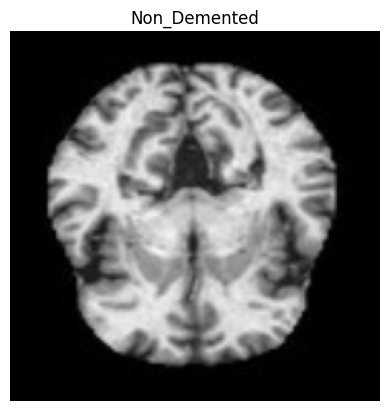

In [19]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # As usual matplotlib dimension is different with Pytorch so we need to permute it into HWC order
plt.title(class_names[label])
plt.axis(False)

## Replicating ViT Overview

Looking at a whole machine learning research paper can be intimidating

So, in order to make it more understandable, we can break it down to smaller pieces.

* **Inputs** - What goes into the model? (In this case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (In this case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (e.g. Self-attention)
* **Blocks** - A collection of layers.
* **Model** - A collection of blocks.

### ViT Overview: Pieces of the puzzle

* Figure 1: Visual overview of the architecture
* 4 Equations: Math equations which define the functions of each layer/block
* Table 1/3: Different Hyperparameters for the architecture/training
* Text

### Figure 1

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true)

* Embedding = learnable representation (start with random numbers and improve over time)

### 4 Equations

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true)

#### Section 3.1 describes the various equations:

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In Pseudocode:
```python

#Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```


**Equation 2 & 3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In Pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```




**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = MultiLayer Perceptron = A neural network with X number of layer
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

In Pseudocode:

```python
# Equation 4
y_output = Linear_layer(LN_layer(x_output_MLP_block))
```



### Table 1

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true)

* ViT-Base, ViT-Large, ViT-Huge are all different sizes of the same model architecture
* ViT-B/16 - ViT-Base with patch size of 16 x 16
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Head - the number of multi-head-self-attention

## Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224,224,3) -> single image -> HWC
* Output shape: ???

### Calculated input and output shapes by hand

> **Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

> **Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^2 \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width)/p^2
* D = constant latent vector size = embedding dimension (see Table 1)

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true)


In [20]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height*width) / patch_size**2)
number_of_patches

196

In [21]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

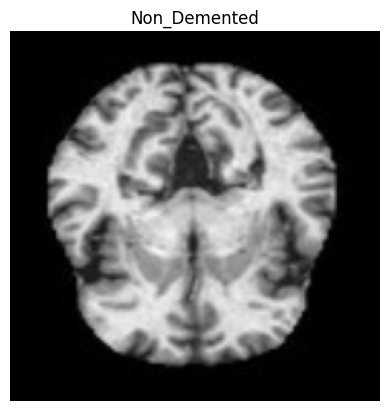

In [22]:
# View a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [23]:
image.shape

torch.Size([3, 224, 224])

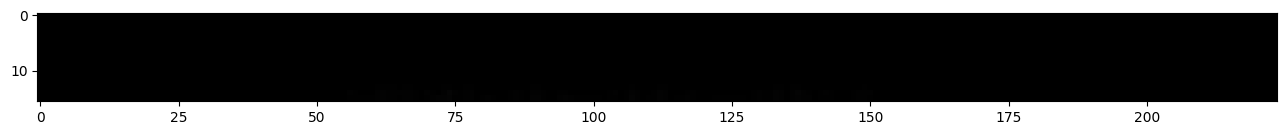

In [24]:
# Get the top row of the image
image_permuted = image.permute(1,2,0) # convert image to color channels last (H,W,C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


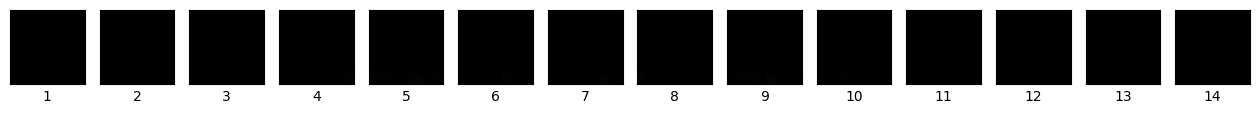

In [25]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, ax = plt.subplots(nrows=1,
                       ncols=img_size // patch_size,
                       sharex=True,
                       sharey=True,
                       figsize=(patch_size, patch_size)) # one column for each patch

# Iterare through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  ax[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  ax[i].set_xlabel(i+1) # set the patch label
  ax[i].set_xticks([])
  ax[i].set_yticks([])

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total Patches: 196.0  
Patch Size: 16 pixels x 16 pixels


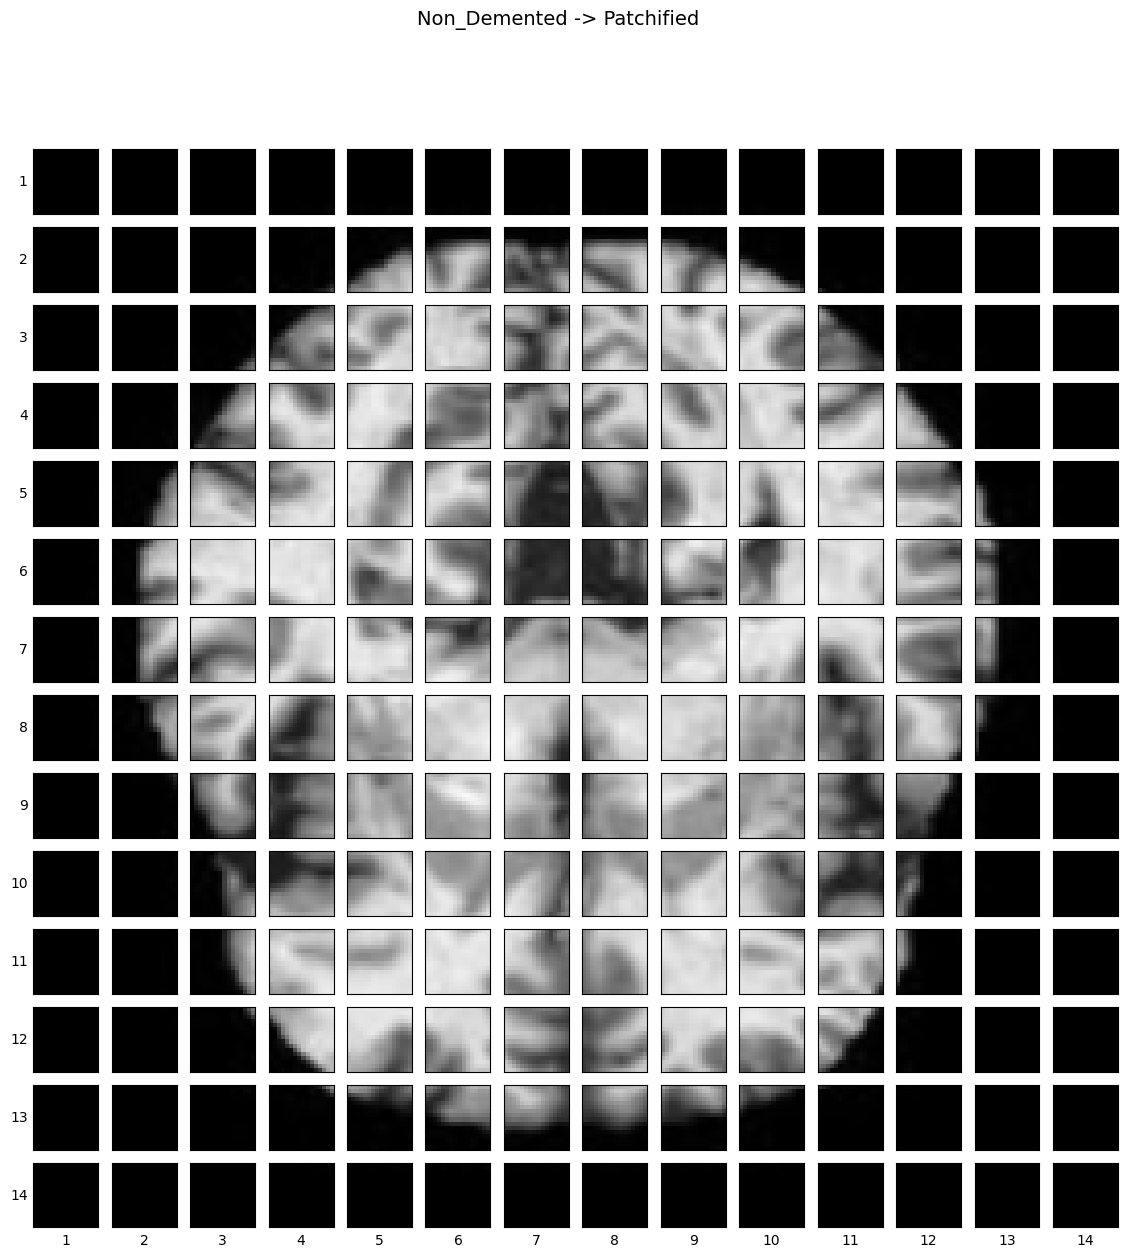

In [26]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image seize must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal Patches: {num_patches*num_patches}\
  \nPatch Size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, ax = plt.subplots(nrows=img_size//patch_size,
                       ncols=img_size//patch_size,
                       figsize=(num_patches, num_patches),
                       sharex=True,
                       sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
    # Plot the permuted image on the different axes
    ax[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                   patch_width:patch_width+patch_size,
                                   :]) # get all color channels
    # Setup label information for each subplot (patch)
    ax[i, j].set_ylabel(i+1,
                        rotation='horizontal',
                        horizontalalignment='right',
                        verticalalignment='center')
    ax[i, j].set_xlabel(j+1)
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    ax[i, j].label_outer()

# Setup title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

## Creating image patches and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d`

In [27]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # for color images
                   out_channels=768, # D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

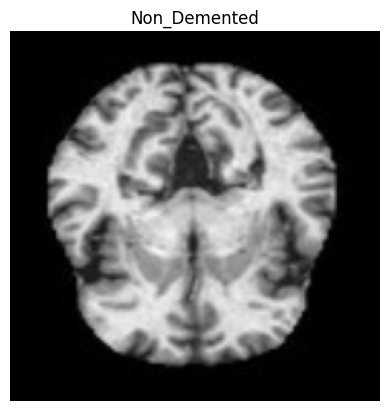

In [28]:
# View single iamge
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [29]:
# Pass the image through conv layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension because conv layer expects that -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [29, 83, 46, 656, 590]


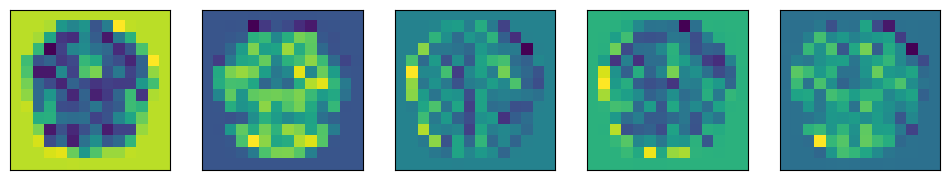

In [30]:
# Plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, ax = plt.subplots(nrows=1, ncols=len(random_indexes), figsize=(12,12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  ax[i].imshow(image_conv_feature_map.squeeze(dim=0).detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### Flattening the patch embedding with `torch.nn.Flatten()`

In [31]:
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [32]:
flatten = nn.Flatten(start_dim=2,
                     end_dim=3)
image_flattened = flatten(image_out_of_conv)
print(image_flattened.shape)

torch.Size([1, 768, 196])


Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


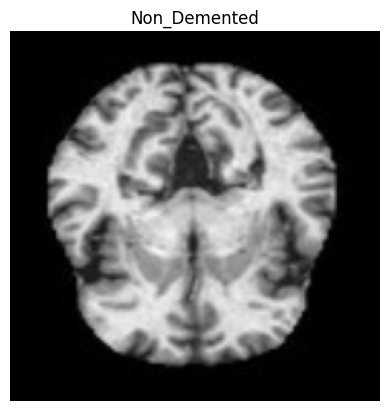

In [33]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(dim=0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [34]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> batch_size, number_of_patches, embedding_dimension")

torch.Size([1, 196, 768]) -> batch_size, number_of_patches, embedding_dimension


(-0.5, 195.5, 0.5, -0.5)

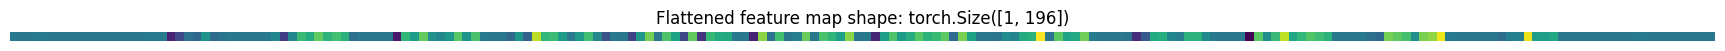

In [35]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

### Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding`
2. Initiatlize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through layer from 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding

In [36]:
# 1. Create a class caledd PatchEmbedding
class PatchEmbedding(nn.Module):
  """Turns a 2D input image into a 1D sequence learnable embedding vector.

  Args:
    in_channels(int): Number of color channels for the input images. Defaults set to 3
    patch_size(int): Size of patches to convert input image into. Defaults set to 16
    embedding_dim(int): Size of embedding to turn image into. Defaults to 768
  """
  # 2. Initialize the layer with appropriate hyperparameters
  def __init__(self, in_channels: int=3,
               patch_size: int=16,
               embedding_dim: int=768):
    super().__init__()

    self.patch_size = patch_size

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch_size, image shape: {image_resolution}, patch_size = {self.patch_size}"

    # Perform the forward pass and permute into the correct shape
    return self.flatten(self.patcher(x)).permute(0, 2, 1)

In [37]:
helper_functions.set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single iamge through patch embedding layer
print(f"Input image size: {image.unsqueeze(dim=0).shape}")
patch_embedded_image = patchify(image.unsqueeze(dim=0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


### Creating the class token embedding

Want to: Prepend a learnable class token to the start of the patch embedding.

In [38]:
patch_embedded_image

tensor([[[-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         ...,
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033]]],
       grad_fn=<PermuteBackward0>)

In [39]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [40]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True)

class_token.shape

torch.Size([1, 1, 768])

In [41]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [42]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                            dim=1) # number of patches dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> batch_size, class_token + number_of_patches, embedding_dimension")

tensor([[[ 0.5436, -0.4700, -1.2133,  ..., -0.4571,  0.4486,  0.1217],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         ...,
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> batch_size, class_token + number_of_patches, embedding_dimension


### Creating the position embedding

Want to: Create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings

In [43]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 0.5436, -0.4700, -1.2133,  ..., -0.4571,  0.4486,  0.1217],
          [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
          [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
          ...,
          [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
          [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
          [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [44]:
# Calculate N (number_of_patches)
number_of_patches = int((height*width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
embedding_dimension

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.randn(1, number_of_patches + 1, embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[-1.0264, -2.4631,  0.1703,  ...,  0.1468,  1.3768,  0.5802],
          [-0.6950,  0.7188, -1.1410,  ..., -0.3153, -2.2221, -0.6922],
          [-1.5855, -0.3176, -1.4012,  ...,  1.7983,  0.5078,  0.0315],
          ...,
          [ 1.2855,  0.8303,  0.1497,  ..., -0.4751,  1.2664,  0.6758],
          [-0.0406, -0.5170, -0.3489,  ..., -0.4922,  0.3503,  1.3471],
          [-0.2454, -0.0047,  1.4984,  ..., -0.4075,  1.5785, -0.3281]]],
        requires_grad=True),
 torch.Size([1, 197, 768]))

In [45]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[-0.4828, -2.9331, -1.0430,  ..., -0.3104,  1.8254,  0.7019],
         [-0.7138,  0.7075, -1.1721,  ..., -0.3047, -2.2254, -0.6889],
         [-1.6043, -0.3290, -1.4323,  ...,  1.8088,  0.5045,  0.0348],
         ...,
         [ 1.2668,  0.8189,  0.1185,  ..., -0.4646,  1.2631,  0.6790],
         [-0.0594, -0.5284, -0.3800,  ..., -0.4816,  0.3470,  1.3504],
         [-0.2641, -0.0161,  1.4673,  ..., -0.3970,  1.5753, -0.3248]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


In [46]:
patch_and_position_embedding[:,:,0]

tensor([[-0.4828, -0.7138, -1.6043, -0.4186, -0.5208,  1.6810, -0.1533, -0.4940,
          0.6627, -1.1726, -0.0488,  0.5580, -0.7956, -1.2940, -0.3050,  2.0729,
          0.5167,  0.6154, -2.7517, -0.5481, -0.7208, -1.9117, -1.9591, -2.6196,
          1.1674, -0.4313,  0.5306, -4.0736,  0.9698,  0.4090, -0.9262,  0.7577,
          1.2699, -0.3090,  0.7836,  0.5403,  0.5747, -1.4528,  0.9844,  1.0977,
         -0.8597, -0.9812,  1.1413,  0.9471,  0.0609, -0.2257, -1.0454, -1.6141,
         -0.8925, -0.3025, -0.5391, -1.5152, -1.0815, -0.6597,  0.3554, -0.9691,
         -0.8327,  0.0579,  1.5041,  0.0824,  1.2488, -0.7354, -2.4371,  1.0755,
         -2.6713, -1.2926,  0.6406, -1.5947, -1.5091,  1.8014, -0.1024, -1.1760,
         -0.3806, -2.1120,  0.6107, -1.1426, -1.3935,  1.1235,  1.6735, -0.2365,
         -0.0438, -1.1738,  0.7947, -0.1283, -0.2966, -0.1436, -0.1637,  1.5402,
          0.4912, -0.7497, -0.0231, -0.7054, -0.8029, -1.4552, -1.3614, -1.2835,
         -0.5232, -0.9830, -

## Putting it all together

[INFO] Successfully created patched images with class token and position embedding


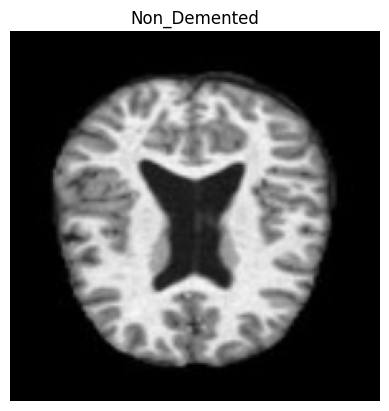

In [47]:
# Set seed
helper_functions.set_seeds()

# Prepare the image from dataloader
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

# Show the original image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

# Define the patch size
patch_size = 16

# Instantiate the patch embedding class to turn the image tensor into patch embedded learnable parameters
patchify = PatchEmbedding(in_channels=3,
                          patch_size=patch_size,
                          embedding_dim=768)

# Patch the image
image_patched = patchify(image.unsqueeze(dim=0)) # add batch dimension to pass it through convolution

# Define the embedding dimension, number of patches and batch_size
number_of_patches = int((height*width) / patch_size**2)
embedding_dimension = image_patched.shape[-1]
batch_size = image_patched.shape[0]

# Create the class token tensor
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True)

# Prepend the class token into the patch embedded image
image_patched_with_class_token = torch.cat((class_token, image_patched), dim=1)

# Create the position embedding
position_embedding = nn.Parameter(torch.randn(batch_size, number_of_patches + 1, embedding_dimension))

# Add the image patched with token with the position embedding
patch_position_image = image_patched_with_class_token + position_embedding
print(f"[INFO] Successfully created patched images with class token and position embedding")


## Equation 2: Multihead Self-Attention (MSA block)

* Multihead Self-Attention: Which part of a sequence should pay the most attention to itself?
  * In this case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation
* To replicate MSA in PyTorch we can use the built-in Multihead Self-Attention function from PyTorch `torch.nn.MultiheadAttention()`

* LayerNorm = A technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = Make everything have the same mean and the same standard deviation
  * In PyTorch: Normalizes values over $D$ dimension, in this case, the $D$ dimension is the embedding dimension, which is 768
    * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.
  
  ![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true)

In [48]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a multi-head self-attention block ("MSA block" for short).
  """
  def __init__(self,
               num_heads: int=12, # Heads from Table 1 for ViT-Base
               embedding_dim: int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
               attn_dropout: int=0):
    super().__init__()
    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention (MSA) layer
    self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     dropout=attn_dropout,
                                                     batch_first=True) # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)

  def forward(self, x):
    norm_x = self.layer_norm(x)
    attention_output, _ = self.multihead_attention(query=norm_x,
                                           key=norm_x,
                                           value=norm_x,
                                           need_weights=False)
    return attention_output + x

In [49]:
# Create an instance of MSA Block
MSABlock = MultiHeadSelfAttentionBlock(num_heads=12, embedding_dim=768, attn_dropout=0) # Hyperparameters based on ViT paper
MSABlock

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = MSABlock(patch_position_image)
print(f"Input shape of MSA block: {patch_position_image.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [50]:
patch_position_image

tensor([[[ 1.1593,  0.8887, -2.4284,  ...,  0.7478,  0.0063,  0.2489],
         [ 0.3482, -0.7450,  0.0037,  ...,  0.9518, -0.9480, -1.4311],
         [-0.1796,  0.6439,  0.5289,  ...,  2.0264,  1.2617, -1.1901],
         ...,
         [-0.9057, -0.3992, -0.7653,  ...,  0.6031,  0.7082,  0.7966],
         [-1.5959, -0.8939, -0.9676,  ...,  0.5813, -1.6266,  0.0785],
         [-0.8401, -1.2035,  0.6141,  ...,  2.2960, -0.9847,  0.8183]]],
       grad_fn=<AddBackward0>)

In [51]:
patched_image_through_msa_block

tensor([[[ 1.1987,  0.8587, -2.5118,  ...,  0.6726, -0.0830,  0.1047],
         [ 0.4205, -0.7835, -0.0946,  ...,  0.8795, -1.0139, -1.5637],
         [-0.1344,  0.6488,  0.4425,  ...,  1.9859,  1.2070, -1.2701],
         ...,
         [-0.8744, -0.4617, -0.8599,  ...,  0.5419,  0.6353,  0.6871],
         [-1.5725, -0.9277, -1.0797,  ...,  0.5365, -1.6671, -0.0300],
         [-0.8085, -1.2347,  0.5132,  ...,  2.2394, -1.0845,  0.7054]]],
       grad_fn=<AddBackward0>)

## Equation 3: MultiLayer Perceptron (MLP) Block

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1)
  * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer
  * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
  * MLP number of hidden units = MLP Size in Tabel 1, which is 3072

* **Dropout** = Dropout, when used, is applied after
every dense layer except for the the qkv-projections and directly after adding positional- to patch
embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.
  * Value for Dropout available in Table 3

In Pseudocode:
```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [52]:
# Create a class that inherits nn.Module
class MLPBlock(nn.Module):
  """Creates a layer normalized multilayer perceptron block (MLP Block) for short
  """
  # Initialize the class with hyperparameters from Table 1 and Table 3
  def __init__(self,
               embedding_dim: int=768,
               mlp_size: int=3072,
               dropout: int=0.1):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  # Create the forward method to pass data through layers
  def forward(self, x):
    return self.mlp(self.layer_norm(x)) + x

In [53]:
# Create an instance of MLP Block
mlp_block = MLPBlock(embedding_dim=768, mlp_size=3072, dropout=0.1)

# Pass the output of the MSABlock through the MLP Block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP Block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP Block: {patched_image_through_mlp_block.shape}")

Input shape of MLP Block: torch.Size([1, 197, 768])
Output shape of MLP Block: torch.Size([1, 197, 768])


In [54]:
patched_image_through_msa_block

tensor([[[ 1.1987,  0.8587, -2.5118,  ...,  0.6726, -0.0830,  0.1047],
         [ 0.4205, -0.7835, -0.0946,  ...,  0.8795, -1.0139, -1.5637],
         [-0.1344,  0.6488,  0.4425,  ...,  1.9859,  1.2070, -1.2701],
         ...,
         [-0.8744, -0.4617, -0.8599,  ...,  0.5419,  0.6353,  0.6871],
         [-1.5725, -0.9277, -1.0797,  ...,  0.5365, -1.6671, -0.0300],
         [-0.8085, -1.2347,  0.5132,  ...,  2.2394, -1.0845,  0.7054]]],
       grad_fn=<AddBackward0>)

In [55]:
patched_image_through_mlp_block

tensor([[[ 1.0838,  0.9935, -2.6759,  ...,  0.6726, -0.3718,  0.1047],
         [ 0.3662, -0.6415, -0.0946,  ...,  1.1867, -1.5470, -1.7103],
         [-0.0814,  0.7880,  0.1881,  ...,  1.7170,  0.8863, -0.8001],
         ...,
         [-0.8784, -0.4617, -0.8904,  ...,  0.5419,  0.6650,  0.8650],
         [-1.4777, -1.1923, -1.2026,  ...,  0.2495, -1.8225, -0.1088],
         [-0.7350, -1.1368,  0.5272,  ...,  2.2592, -1.1501,  0.5498]]],
       grad_fn=<AddBackward0>)

## Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (Equation 2) and MLP (Equation 3)

And there are residual connections between each block

* Encoder = turn a sequnce into learnable representation
* Decode = go from learned representation back to some sort of sequence
* Residual/Skip connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks since it prevents the weights from getting too small

In Pseudocode:
```python
# Transformer Encoder
x_input -> MSA Block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### Create a custom Transformer Encoder block

In [56]:
class TransformerEncoder(nn.Module):
  def __init__(self,
               embedding_dim: int=768, # Hidden size D from Table 1, 768 for ViT-Base
               num_heads: int=12, # from table 1
               mlp_size: int=3072, # from table 1
               mlp_dropout: int=0.1, # from table 3
               attn_dropout: int=0):
    super().__init__()

    # Create MSA block (Equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(num_heads=num_heads,
                                                 embedding_dim=embedding_dim,
                                                 attn_dropout=attn_dropout)

    # Create MLP block (Equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    return self.mlp_block(self.msa_block(x))

In [57]:
# Create an instance of TransformerEncoder()
transformer_encoder = TransformerEncoder()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder,
        input_size=[1, 197, 768],
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)                 [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

### Create a Transformer Encoder layer with in-built PyTorch layers

Benefits of using a pre-built PyTorch layer:
1. Less prone to errors (goes through a bunch of testing)
2. Potential benefit of speeds up (performance boost)


In [58]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from Table 1
                                                             nhead=12, # Head size from Table 1
                                                             dim_feedforward=3072, # MLP size from Table 1
                                                             dropout=0.1, # Dropout from Table 3
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True) # Norm Layer first before self-attention

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [59]:
transformer_encoder

TransformerEncoder(
  (msa_block): MultiHeadSelfAttentionBlock(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (multihead_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
  )
  (mlp_block): MLPBlock(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=3072, out_features=768, bias=True)
      (4): Dropout(p=0.1, inplace=False)
    )
  )
)

In [60]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=[1, 197, 768],
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Putting it all together to create ViT

In [61]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
             img_size: int=224, # Table 3 from the ViT paper
             in_channels: int=3,
             patch_size: int=16,
             num_transformer_layer: int=12, # Table 1 "Layers" for ViT-Base
             embedding_dim: int=768, # Hidden size D from Table 1 for ViT-Base
             mlp_size: int=3072, # Table 1
             num_heads: int=12, # Table 1
             attn_dropout: int=0,
             mlp_dropout: int=0.1,
             embedding_dropout: int=0.1, # Dropout for patch and position embeddings
             num_classes: int=1000): # Number of classes in the classification problem
    super().__init__()

    # Make an assertion for image size (must be compatible with patch size)
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch_size: {patch_size}"

    # Calculate the number of patches
    self.number_of_patches = int((img_size * img_size) / patch_size**2) # Formula from the ViT paper

    # Create learnable class token embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.number_of_patches+1, embedding_dim),
                                           requires_grad=True)

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding_layer = PatchEmbedding(in_channels=in_channels,
                                                patch_size=patch_size,
                                                embedding_dim=embedding_dim)

    # Create the transformer encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoder(embedding_dim=embedding_dim,
                                                                  num_heads=num_heads,
                                                                  mlp_size=mlp_size,
                                                                  mlp_dropout=mlp_dropout) for _ in range(num_transformer_layer)])

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch_size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (Equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension

    # Create the patch embedding (Equation 1)
    x = self.patch_embedding_layer(x)

    # Concat class token embedding and patch embedding (Equation 1)
    x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches, embedding_dim)

    # Add position embedding to class token and patch_embedding
    x = self.position_embedding + x

    # Apply dropout
    x = self.embedding_dropout(x)

    # Pass the position and patch embedding to the transformer encoder (Equation 2 & 3)
    x = self.transformer_encoder(x)

    # Put 0th index logit through the classifier (Equation 4)
    x = self.classifier(x[:, 0])

    return x

In [62]:
ViTModel= ViT(num_classes=len(class_names))
ViTModel

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding_layer): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoder(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
  

In [63]:
helper_functions.set_seeds()

# Create a random image tensor with a same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (normal, pneumonia)
ViTModel = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
ViTModel(random_image_tensor)

tensor([[ 0.3545,  0.5998,  1.1518, -0.6518]], grad_fn=<AddmmBackward0>)

In [64]:
### Getting a visual summary of the ViT Model
summary(model=ViTModel,
        input_size=[1, 3, 224, 224],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [1, 3, 224, 224]     [1, 4]               152,064              True
├─PatchEmbedding (patch_embedding_layer)                          [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                           [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                          [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoder (0)                                